In [31]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, precision_score, recall_score, f1_score
from collections import Counter
import shutil
import os
import random
import cv2
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.applications import VGG16
from keras.layers import MaxPooling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [3]:

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [4]:
def copy_images(src_directory, dst_directory):
    # Check if the destination directory exists, if not, create it
    if not os.path.exists(dst_directory):
        os.makedirs(dst_directory)
    
    # Walk through the source directory
    for root, dirs, files in os.walk(src_directory):
        for file in files:
            # Build the path to the source file
            src_file = os.path.join(root, file)
            # Build the destination path while maintaining the directory structure
            dst_file = os.path.join(dst_directory, os.path.relpath(src_file, src_directory))
            # Create any directories needed in the destination path
            os.makedirs(os.path.dirname(dst_file), exist_ok=True)
            # Copy the file from source to destination
            shutil.copy(src_file, dst_file)
src_dir = '../data/landing'
dst_dir = '../data/curated'            
copy_images(src_dir, dst_dir)

In [5]:

# Define the directory paths
train_dir = '../data/curated/train'
val_dir = '../data/curated/valid'

train_datagen = ImageDataGenerator(
    rescale = 1.0/255.0,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)

# Only normalise the validation and test data, don't augumented it
val_datagen = ImageDataGenerator(
    rescale = 1.0/255.0,
)



train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (224,224),
    batch_size = 64,
    class_mode = 'categorical'
)



validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    batch_size= 64,
    class_mode='categorical'
)



Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


In [9]:
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, Flatten, Dense, GlobalAveragePooling2D, Reshape, Multiply

def squeeze_excitation_block(input, ratio=16):
    init = input
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x


def residual_block(x, filters, kernel_size, stride):
    shortcut = x
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = squeeze_excitation_block(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x


input_tensor = Input(shape=(224, 224, 3))
vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

x = vgg16.layers[-1].output
x = residual_block(x, 512, 3, 1)
x = residual_block(x, 512, 3, 1)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=input_tensor, outputs=predictions)
model.summary()


optimizer = tf.keras.optimizers.SGD()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 100
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    verbose=1
)


2024-11-17 15:57:43.991195: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-11-17 15:57:43.991220: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-17 15:57:43.991226: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-17 15:57:43.991247: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-17 15:57:43.991265: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 50,447,684 (192.44 MB)

 Trainable params: 50,442,564 (192.42 MB)

 Non-trainable params: 5,120 (20.00 KB)

/Users/minhquan/tf-metal-env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


2024-11-17 15:57:45.842082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


10/10 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.2945 - loss: 3.8328 - val_accuracy: 0.1806 - val_loss: 26.7753
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.4320 - loss: 1.6373 - val_accuracy: 0.1806 - val_loss: 48.8763
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.4750 - loss: 1.2329 - val_accuracy: 0.1806 - val_loss: 62.7134
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.5120 - loss: 1.1293 - val_accuracy: 0.2222 - val_loss: 5.2507
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.5138 - loss: 1.0038 - val_accuracy: 0.2639 - val_loss: 2.0223
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.5598 - loss: 1.0254 - val_accuracy: 0.1806 - val_loss: 5.2115
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.5473 - loss: 0.9753 - val_accuracy: 0.2083 - val_loss: 3.2295
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.6376 - loss: 0.8121 - val_accuracy: 0.2361 - val_loss: 

In [26]:
test_dir = '../data/curated/test'

test_datagen = ImageDataGenerator(
    rescale = 1.0/255.0
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (224, 224),
    batch_size = 64,
    class_mode = 'categorical',
    shuffle = False,
)

Found 315 images belonging to 4 classes.


In [27]:
test_loss, test_accuracy = model.evaluate(test_generator)
print('Test accuracy:', test_accuracy)

/Users/minhquan/tf-metal-env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9209 - loss: 0.2898 
Test accuracy: 0.8857142925262451


In [28]:

num_test_samples = len(test_generator)
num_classes = len(test_generator.class_indices)
predicted_probabilities = model.predict(test_generator, steps=num_test_samples)
predicted_labels = np.argmax(predicted_probabilities, axis=1)
true_labels = test_generator.classes



5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 877ms/step


In [32]:
# Compute accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Compute precision (macro-averaged across all classes)
precision = precision_score(true_labels, predicted_labels, average='macro')
print(f"Precision (macro): {precision:.4f}")

# Compute recall (macro-averaged across all classes)
recall = recall_score(true_labels, predicted_labels, average='macro')
print(f"Recall (macro): {recall:.4f}")

# Compute F1-score (macro-averaged across all classes)
f1 = f1_score(true_labels, predicted_labels, average='macro')
print(f"F1-Score (macro): {f1:.4f}")

Accuracy: 0.8857
Precision (macro): 0.9171
Recall (macro): 0.8684
F1-Score (macro): 0.8855


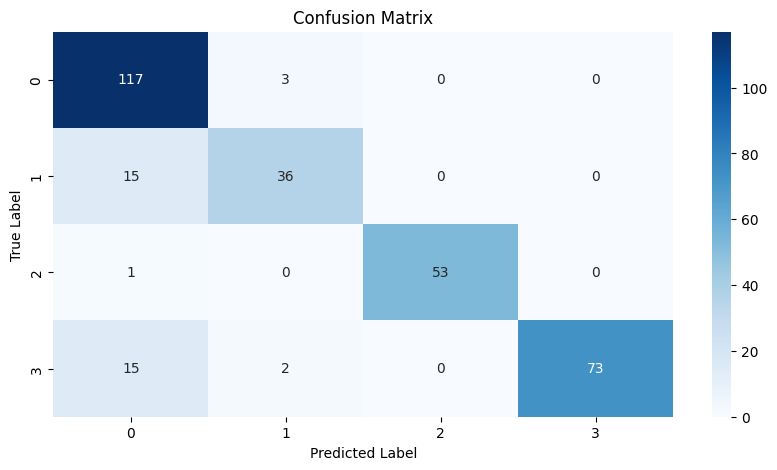

In [33]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(10, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Accuracy: 0.3206
Precision (macro): 0.2623
Recall (macro): 0.2649
F1-Score (macro): 0.2613
